In [1]:
%matplotlib inline
from tqdm import tqdm
import numpy as np
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.dist_math import binomln, betaln, bound
np.set_printoptions(suppress=True)

Using cuDNN version 7104 on context None
Mapped name None to device cuda0: GeForce GTX 1080 Ti (0000:86:00.0)
Mapped name dev0 to device cuda0: GeForce GTX 1080 Ti (0000:86:00.0)
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/Users/ded/anaconda3/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 238, in <module>
    init_dev(d.strip(), n.strip())
  File "/Users/ded/anaconda3/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 99, in init_dev
    **args)
  File "pygpu/gpuarray.pyx", line 658, in pygpu.gpuarray.init
  File "pygpu/gpuarray.pyx", line 587, in pygpu.gpuarray.pygpu_init
pygpu.gpuarray.GpuArrayException: b'cuDeviceGet: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal'
/Users/ded/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64

In [2]:
# Helper function for visualization
import re
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [51]:
import pickle
with open('data/vch-2000-10-0.12-8.50.pkl', 'rb') as f:
  GCH, TH = pickle.load(f)

# Sample periods and observed workers
S = 10
rawdata = np.array(GCH, dtype = int)
V = len(GCH)

# make capture history data
data, freqs = np.unique(rawdata, axis = 0, return_counts = True)
H = len(freqs)

print('Sampling periods:', S)
print('Unique patterns:', H)
print('Unique workers:', V)

Sampling periods: 10
Unique patterns: 30
Unique workers: 103


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]
100%|██████████| 3000/3000 [00:08<00:00, 351.66it/s]
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7085566461247509, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


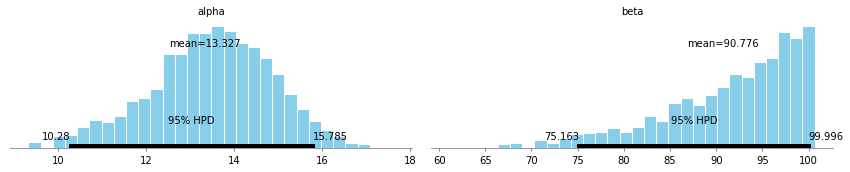

In [50]:
with pm.Model() as model0:
    alpha0 = pm.Uniform('alpha', 0, 100)
    beta0 = pm.Uniform('beta', 0, 100)
    X0 = pm.BetaBinomial('X', alpha=alpha0, beta=beta0, n=S, observed=rawdata[:, 2])
    trace0 = pm.sample(2000, tune=1000, cores = 1)
    pm.plot_posterior(trace0, varnames = ['alpha', 'beta']);

In [25]:
# We want to see the survival marks to compute the total survival
# e.g, Arrive: 1, Depart: 2 => 011
# Dims: SxSxS
def make_survival(S):
    mask = np.zeros([S,S,S])  # arrival, departure, presence_sequence
    for s in np.arange(S):
        for q in np.arange(s,S):
            c1 = np.zeros(s)
            c2 = np.ones(q-s)
            c3 = np.zeros(S-q)
            mask[s,q]= np.concatenate((c1, c2, c3))
    return mask
survival = make_survival(S)
survival.shape

(10, 10, 10)

In [26]:
# A more compact way to represent all Arrival and departures from the data
# This is part of the input data, so we preprocess it!
def get_hmask(S, H, data):
    h_mask = np.zeros((H,S,S))
    for wh in np.arange(H):
        f, l = data[wh, 0] , data[wh, 1]
        h_mask[wh, :f+1, l:] = 1
    return h_mask
hmask = get_hmask(S, H, data)
hmask.shape

(30, 10, 10)

In [27]:
# For a given outcome in {1,S} (Frequency of capture that's not 0) 
# Generate the Binomial parameters n and i   choose(n, i)
# Nn is the duration from arrival to departure
# Ni is the Frequency we are intersted in
# Dim: SxSxS
def make_binmask(S, data):
    i = data[:,2]
    i = i[:, np.newaxis, np.newaxis] *  np.ones((H, S, S))
    n = np.broadcast_to(np.triu(np.ones([S,S]), 0).cumsum(axis =1), (H, S, S))
    return i, n
Ni, Nn = make_binmask(S, data)
print('Tensor with number of captures', Ni.shape)
print('Tensor with durations from first to last seen', Nn.shape)

Tensor with number of captures (30, 10, 10)
Tensor with durations from first to last seen (30, 10, 10)


In [28]:
# Helper functions for the Beta Bernoulli Process
# TODO: switch to a single function even for the special case of 0 captures.

def get_BetaBi(a,b, S, Ni, Nn):
    # The beta binomial
    BBi  =  bound(betaln(Ni + a, Nn - Ni + b) - betaln(a, b),
                     Ni >= 0, Ni <= Nn,
                     a > 0, b > 0)
    # The above is the computation of the log, so we take the exponent
    return tt.exp(BBi)

def get_BetaB0(a, b, S):
    # The beta binomial for 0 captures
    Nn = tt.triu(tt.ones([S,S]), 0).cumsum(axis =1).eval()
    #B0 = tt.gammaln(n + b) - tt.gammaln(n + a + b) + tt.gammaln(a + b) - tt.gammaln(b)
    B0 = bound(betaln(a, Nn + b) - betaln(a, b), 
               a > 0, b > 0)
    return tt.exp(B0)

In [29]:
def logp_capture(arrival_probs, departure_probs, a, b, U, survival_mask, Ni, Nn, S, V):
    def ll_capture_f(Nh, data_first_last_mask):
          
        # Likelihood of observing Li captures
        
        # compute the survival
        survival_prob = tt.pow(1 - departure_probs, survival_mask)
        survival_prob = tt.prod(survival_prob, axis=2)
        # compute the arrival and departure
        LAD      = arrival_probs[:, np.newaxis] * survival_prob * departure_probs    # SxS
        # keep only true possibilites
        True_LAD = LAD * data_first_last_mask # SxSxS
        
        # sum along the freqencies of catpures
        BetaBi  = get_BetaBi(a, b, S, Ni, Nn)
        Li      = tt.batched_tensordot(True_LAD, BetaBi, axes = 2) # S
        
        # Likelihood of No-Capture L0
        
        True_LAD0    = LAD * tt.triu(tt.ones((S,S)), 0)
        BetaB0   = get_BetaB0(a, b, S)
        L0       = tt.sum(True_LAD0 * BetaB0)
        
        # Multinomial
        obj1 = tt.gammaln(V + U + 1) - tt.gammaln(U + 1) - tt.sum(tt.gammaln(Nh+1))
        obj2 = tt.sum(Nh * tt.log(Li))
        obj3 = U * tt.log(L0)
        
        objective = obj1 + obj2 + obj3 
        
        return objective
    
    return ll_capture_f

In [31]:
# model setup
with pm.Model() as model:
    # parameters
    U = pm.Uniform('Unseen', lower=500, upper=10000)
    a = pm.Uniform('alpha', 0., 1.)
    b = pm.Uniform('beta', 1., 15.)
    
    phi = tt.zeros(S)
    phi_v    = pm.Uniform('departure', 0, .3, shape=S-1)
    phi = tt.set_subtensor(phi[S-1], 1.)
    phi = tt.set_subtensor(phi[:S-1],phi_v)
    
    arr    = pm.Dirichlet('arrival', a=np.array([1./S]*S), shape=S)
    
    # Model Log-likelihood
    ob = pm.DensityDist('x', logp_capture(arr, phi, a, b, U, survival, Ni, Nn, S, V), 
                        observed={'Nh': freqs ,
                                  'data_first_last_mask': hmask})

In [35]:
with model:
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=40000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=20000)
    trace_vi = approx.sample(10000) 
    
    elbos1 = -inference.hist

Average Loss = 114.55: 100%|██████████| 40000/40000 [22:26<00:00, 29.71it/s]
Finished [100%]: Average Loss = 114.56
Average Loss = 113.99: 100%|██████████| 20000/20000 [11:11<00:00, 29.76it/s]
Finished [100%]: Average Loss = 113.99


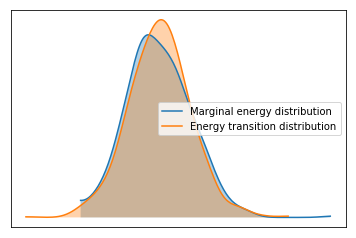

In [36]:
pm.energyplot(posterior);

/Users/ded/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


IndexError: index 5 is out of bounds for axis 0 with size 5

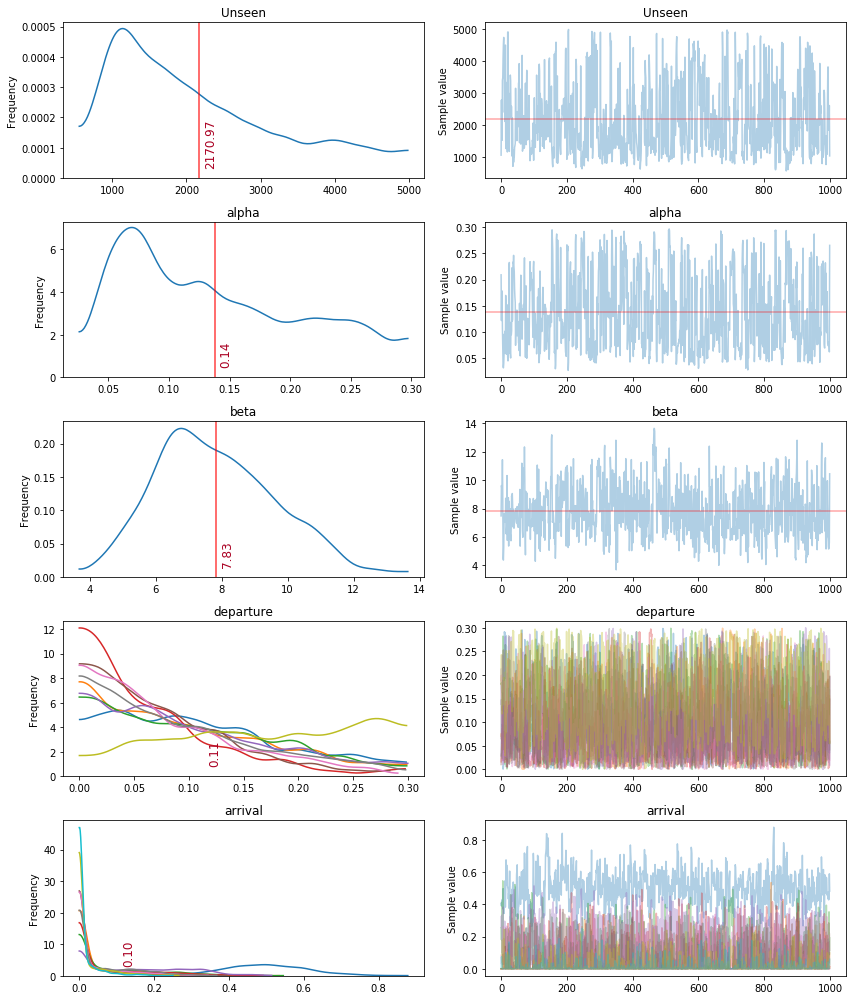

In [37]:
plot_traces(posterior);

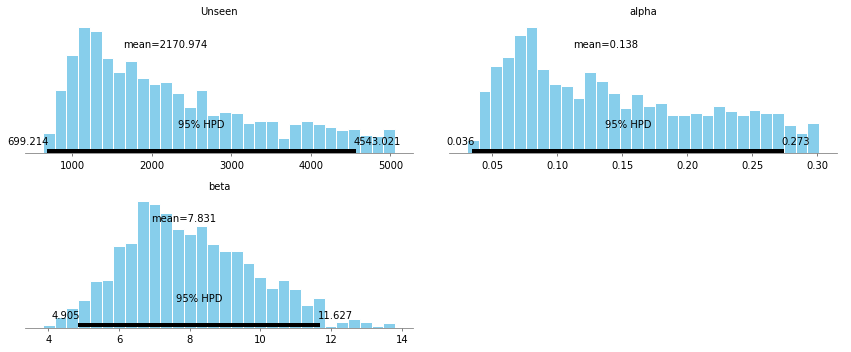

In [44]:
pm.plot_posterior(posterior, varnames = ['Unseen', 'alpha', 'beta']);

In [38]:
pm.summary(posterior)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Unseen,2170.974160,1125.456425,61.880654,6.992140e+02,4543.021479
alpha,0.137639,0.072513,0.004092,3.624176e-02,0.272862
beta,7.830825,1.818413,0.083347,4.905201e+00,11.626707
departure__0,0.113375,0.076276,0.003022,4.293021e-04,0.259222
departure__1,0.102380,0.076546,0.003036,1.262774e-04,0.253697
departure__2,0.107997,0.076416,0.003170,6.686387e-04,0.248430
departure__3,0.069227,0.062483,0.003034,9.203422e-05,0.194774
departure__4,0.103654,0.076990,0.002962,1.718922e-04,0.255107
departure__5,0.077813,0.061557,0.002488,5.764763e-04,0.207332
departure__6,0.082362,0.067095,0.002641,8.030343e-05,0.219185


In [ ]:
print("Total Workers", V + posterior['Unseen'].mean())